In [33]:
import os
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
#Reading data (already extracted)
matched_ratings = pd.read_csv("src/data/data_matched_beer_data/ratings.csv", header=[0, 1])

#Combining columns for easier overview
matched_ratings.columns = ['_'.join(col).strip() for col in matched_ratings.columns.values]

In [35]:
#Changing data column from s to days
matched_ratings['ba_date'] = pd.to_datetime(matched_ratings['ba_date'], unit='s')
matched_ratings['rb_date'] = pd.to_datetime(matched_ratings['rb_date'], unit='s')

# Determining first review date
beer_first_review = matched_ratings.groupby('ba_beer_id').agg(
    first_review_date=('ba_date', 'min')
).reset_index()

# Add first review column
matched_ratings = matched_ratings.merge(beer_first_review, on='ba_beer_id', how='left')

# Calculate one year after the beer's first review
matched_ratings['one_year_after_launch'] = matched_ratings['first_review_date'] + pd.DateOffset(years=1)

# Filter reviews to be within the first year
first_year_reviews = matched_ratings[
    (matched_ratings['ba_date'] >= matched_ratings['first_review_date']) &
    (matched_ratings['ba_date'] < matched_ratings['one_year_after_launch'])]

# Determine the total amount of reviews in the first year
first_year_review_counts = first_year_reviews.groupby('ba_beer_id').size().reset_index(name='first_year_reviews')

# Get total reviews
total_review_counts = matched_ratings.groupby('ba_beer_id').size().reset_index(name='total_reviews')


In [36]:
# Merge all review counts
newcomer_beers = total_review_counts.merge(
    first_year_review_counts, on='ba_beer_id', how='left'
).fillna(0)

# Threshold for beers with enough first year reviews (10)
newcomer_beers = newcomer_beers[newcomer_beers['first_year_reviews'] > 10]

# Sort by highest amount of first-year reviews
newcomer_beers = newcomer_beers.sort_values(by='first_year_reviews', ascending=False)

# Merge with beer names
top_newcomer_beers = newcomer_beers.merge(
    matched_ratings[['ba_beer_id', 'ba_beer_name']].drop_duplicates(),
    on='ba_beer_id',
    how='left'
)

print("Top Newcomer Beers with Most Reviews in First Year:")
print(top_newcomer_beers[['ba_beer_name', 'first_year_reviews', 'total_reviews']])


Top Newcomer Beers with Most Reviews in First Year:
                             ba_beer_name  first_year_reviews  total_reviews
0                            Consecration                  21             76
1                                   Resin                  18             46
2                     Sip Of Sunshine IPA                  15             22
3                      Brooklyn Black OPS                  15             41
4                                  3Beans                  14             15
5          Captain Sig's Northwestern Ale                  13             24
6                                  Hi-Res                  13             19
7                        Galaxy White IPA                  13             22
8                            Oatmeal Yeti                  12             15
9                           Second Fiddle                  12             13
10                      Simtra Triple IPA                  12             24
11                      

In [37]:


matched_ratings['year'] = matched_ratings['ba_date'].dt.year
reviews_per_beer_for_year = matched_ratings.groupby(['ba_beer_id', 'year']).size().reset_index(name='review_count')

# Calculation for mean reviews per year
total_reviews_yearly = matched_ratings.groupby('year').size().reset_index(name='total_review_count')
unique_beers_yearly = matched_ratings.groupby('year')['ba_beer_id'].nunique().reset_index(name='unique_beer_count')
reviews_stats_per_year = total_reviews_yearly.merge(unique_beers_yearly, on='year')
reviews_stats_per_year['mean_reviews_per_beer'] = reviews_stats_per_year['total_review_count'] / reviews_stats_per_year['unique_beer_count']

# Calculation for median
reviews_per_beer_per_year_all = matched_ratings.groupby(['year', 'ba_beer_id']).size().reset_index(name='review_count')
median_reviews_per_year = reviews_per_beer_per_year_all.groupby('year')['review_count'].median().reset_index(name='median_reviews_per_beer')

# Merge median and mean results
reviews_stats_per_year = reviews_stats_per_year.merge(median_reviews_per_year, on='year')

# Get the IDs and names of the top 3 beers
top_beer_ids = top_newcomer_beers['ba_beer_id'].tolist()
top_beer_names = top_newcomer_beers[['ba_beer_id', 'ba_beer_name']]

# Filter reviews for top beers
top_reviews = reviews_per_beer_for_year[reviews_per_beer_for_year['ba_beer_id'].isin(top_beer_ids)]

# Merge beer names
top_reviews = top_reviews.merge(top_beer_names, on='ba_beer_id', how='left').sort_values(by='review_count', ascending=False)
print(top_reviews)

    ba_beer_id  year  review_count                           ba_beer_name
24       45653  2009            20                           Consecration
50       77299  2012            17                                  Resin
25       45653  2010            15                           Consecration
61       88889  2013            14                                 3Beans
71      110895  2014            13                                 Hi-Res
..         ...   ...           ...                                    ...
66       92640  2016             1  Drie Fonteinen Intense Red Oude Kriek
38       51071  2012             1         Captain Sig's Northwestern Ale
62       88889  2014             1                                 3Beans
47       77230  2014             1                       Galaxy White IPA
41       51071  2015             1         Captain Sig's Northwestern Ale

[83 rows x 4 columns]


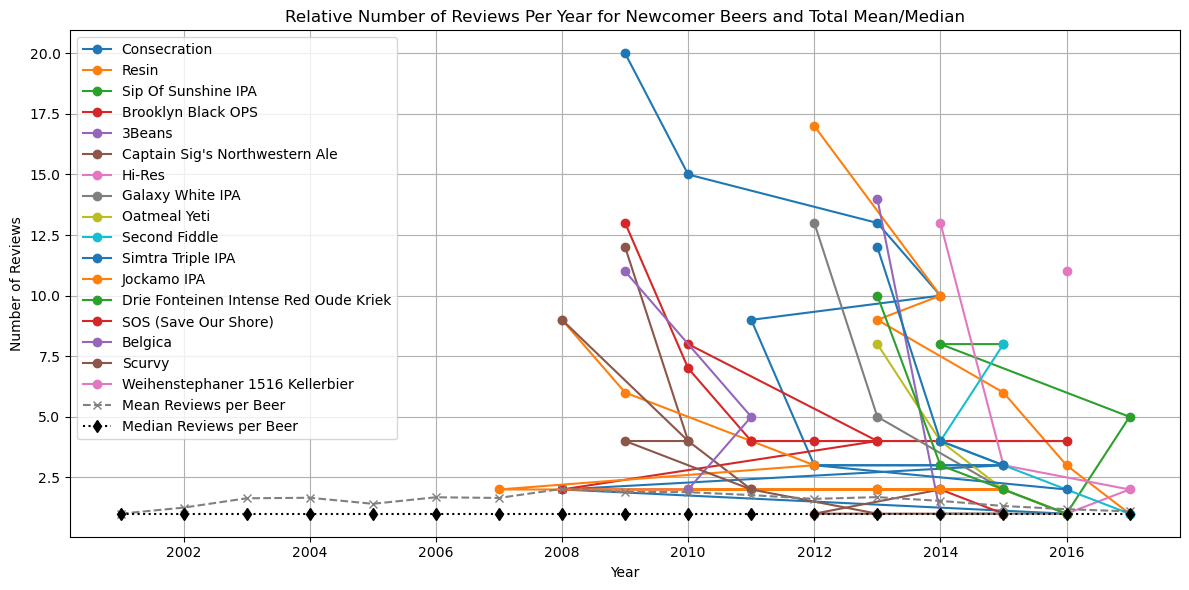

In [40]:
plt.figure(figsize=(12, 6))

# Plot newcomers
for beer_id, beer_name in zip(top_newcomer_beers['ba_beer_id'], top_newcomer_beers['ba_beer_name']):
    beer_data = top_reviews[top_reviews['ba_beer_id'] == beer_id]
    plt.plot(beer_data['year'], beer_data['review_count'], marker='o', label=f"{beer_name}")

# Plot yearly mean 
plt.plot(reviews_stats_per_year['year'], reviews_stats_per_year['mean_reviews_per_beer'], 
         marker='x', linestyle='--', color='gray', label='Mean Reviews per Beer')

# Plot yearly meedian
plt.plot(reviews_stats_per_year['year'], reviews_stats_per_year['median_reviews_per_beer'], 
         marker='d', linestyle=':', color='black', label='Median Reviews per Beer')

plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Relative Number of Reviews Per Year for Newcomer Beers and Total Mean/Median')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()